In [1]:
!pip install simpletransformers

import gc
!del variables
gc.collect()

import torch
torch.cuda.memory_summary(device=None, abbreviated=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 12.7 MB/s 
     |████████████████████████████████| 7.6 MB 54.0 MB/s 
     |████████████████████████████████| 43 kB 1.0 MB/s 
     |████████████████████████████████| 9.2 MB 28.9 MB/s 
     |████████████████████████████████| 451 kB 24.8 MB/s 
     |████████████████████████████████| 1.3 MB 48.1 MB/s 
     |████████████████████████████████| 5.8 MB 17.5 MB/s 
     |████████████████████████████████| 1.9 MB 65.4 MB/s 
     |████████████████████████████████| 182 kB 57.4 MB/s 
     |████████████████████████████████| 182 kB 61.4 MB/s 
     |████████████████████████████████| 168 kB 64.4 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 168 kB 72.2 MB/s 
     |████████████████████████████████| 166 kB 68.7 MB/s 
     |████████████████████████████████| 166 kB 78.9 MB/s 
     |█████████████████████████████

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import torch

data = pd.read_csv('/content/gdrive/My Drive/nlp243/CommitmentBank-items.csv')
data

Mounted at /content/gdrive


,Unnamed: 0,uID,Verb,Embedding,Context,Target,Prompt,ModalType,MatTense,MatSubjLemma,MatSubjPer,MatSubjNum,Embedding.1,genre,factive,mean.noTarget,sd.noTarget,Mean,SD,Reponses
0,1,BNC-1,admit,conditional,Polly had to think quickly.,They were still close enough to shore for him ...,Polly was not an experienced ocean sailor,NaN,future,she,third,singular,conditional,BNC,no,-0.111111,1.269296,2.000000,0.866025,"2, 3, 3, 1, 3, 1, 2, 1, 2"
1,2,BNC-1002,say,modal,"Nevertheless, life went on as it always does. ...",Indeed it could be said that they had prospered.,the Kiwi Keith and the Mackenzie houses had pr...,CI,present,it,third,singular,modal,BNC,no,1.200000,1.873796,1.875000,0.834523,"2, 1, 3, 1, 2, 2, 3, 1"
2,3,BNC-1003,say,modal,"He patted her hand. If he had chosen to, Thoma...",He might have said to her that some time in th...,some time in the middle of the nineteenth cent...,AB,present,he,third,singular,modal,BNC,no,-0.250000,0.462910,0.666667,1.154701,"2, 0, 1, 0, 0, 3, -1, 0, 1, 0, 0, 2"
3,4,BNC-1005,say,modal,She could see his distorted image in the slant...,Of course she could say it was for the childre...,it was for the children,AB,future,she,third,singular,modal,BNC,no,0.636364,1.120065,0.875000,0.991031,"2, 1, 0, 1, -1, 1, 1, 2"
4,5,BNC-1006,say,modal,"She glanced around the room, laying her hot fl...",Robyn swallowed and took a deep breath trying ...,it was all right,AB,future,she,third,singular,modal,BNC,no,-1.090909,1.044466,0.000000,2.309401,"3, 1, -2, -3, -3, 3, 2, 1, -1, -1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1196,WSJ-95,feel,negation,"Across the board, these consumers value qualit...",Twenty percent don't even feel they are financ...,they are financially well off,NaN,present,twenty percent,third,plural,negation,WSJ,no,-1.750000,1.035098,-1.000000,2.371708,"-2, 3, -3, -3, -2, -3, -3, 2, -3, -1, 3, -3, 0..."
1196,1197,WSJ-96,mean,negation,The Fed has assumed a similar responsibility i...,This does not mean that the Federal Reserve do...,the Federal Reserve does not already play an i...,NaN,present,this,third,singular,negation,WSJ,no,-0.722222,1.964555,0.125000,2.028957,"2, -2, 3, 0, 2, 1, 2, -2, 2, 1, -1, 0, -2, -3,..."
1197,1198,WSJ-97,expect,modal,Under the Racketeer Influenced and Corrupt Org...,"In a letter, prosecutors told Mr. Antar's lawy...",any fees collected from Mr. Antar may be seized,AB,present,they,third,plural,modal,WSJ,no,1.600000,1.264911,2.058824,1.477777,"1, 3, -3, 3, 3, 3, 2, 2, 1, 2, 2, 3, 2, 2, 3, ..."
1198,1199,WSJ-98,believe,negation,"Talks between the two sides could unravel, of ...",And although Warner has said it wanted the pro...,the relationship could be repaired after the a...,NaN,present,they,third,plural,negation,WSJ,no,1.083333,1.378954,-1.733333,1.751190,"-1, -3, -3, -1, -2, 1, -3, -3, -3, -3, 2, -2, ..."


In [3]:
# now try to category the mean score the -1, 0, 1
def get_categorize_score(data):
  categorize_score = []
  # data.insert(data.shape[1], 'd', 0)
  for i in range(len(data)):
  # we categorize [-3,-1) to -1, represent the negative
    if data.iloc[i]['Mean'] >= -3 and data.iloc[i]['Mean'] < -1:
       categorize_score.append(0)
  # [-1,1) to 0, represent uncertain
    if data.iloc[i]['Mean'] >= -1 and data.iloc[i]['Mean'] < 1:
      categorize_score.append(1)
  # [1,3] to 1, represent right
    if data.iloc[i]['Mean'] <= 3 and data.iloc[i]['Mean'] >= 1:
      categorize_score.append(2)
  data.insert(data.shape[1], 'categorize_score', categorize_score)
  return data

data = get_categorize_score(data)
data

,Unnamed: 0,uID,Verb,Embedding,Context,Target,Prompt,ModalType,MatTense,MatSubjLemma,...,MatSubjNum,Embedding.1,genre,factive,mean.noTarget,sd.noTarget,Mean,SD,Reponses,categorize_score
0,1,BNC-1,admit,conditional,Polly had to think quickly.,They were still close enough to shore for him ...,Polly was not an experienced ocean sailor,NaN,future,she,...,singular,conditional,BNC,no,-0.111111,1.269296,2.000000,0.866025,"2, 3, 3, 1, 3, 1, 2, 1, 2",2
1,2,BNC-1002,say,modal,"Nevertheless, life went on as it always does. ...",Indeed it could be said that they had prospered.,the Kiwi Keith and the Mackenzie houses had pr...,CI,present,it,...,singular,modal,BNC,no,1.200000,1.873796,1.875000,0.834523,"2, 1, 3, 1, 2, 2, 3, 1",2
2,3,BNC-1003,say,modal,"He patted her hand. If he had chosen to, Thoma...",He might have said to her that some time in th...,some time in the middle of the nineteenth cent...,AB,present,he,...,singular,modal,BNC,no,-0.250000,0.462910,0.666667,1.154701,"2, 0, 1, 0, 0, 3, -1, 0, 1, 0, 0, 2",1
3,4,BNC-1005,say,modal,She could see his distorted image in the slant...,Of course she could say it was for the childre...,it was for the children,AB,future,she,...,singular,modal,BNC,no,0.636364,1.120065,0.875000,0.991031,"2, 1, 0, 1, -1, 1, 1, 2",1
4,5,BNC-1006,say,modal,"She glanced around the room, laying her hot fl...",Robyn swallowed and took a deep breath trying ...,it was all right,AB,future,she,...,singular,modal,BNC,no,-1.090909,1.044466,0.000000,2.309401,"3, 1, -2, -3, -3, 3, 2, 1, -1, -1",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1196,WSJ-95,feel,negation,"Across the board, these consumers value qualit...",Twenty percent don't even feel they are financ...,they are financially well off,NaN,present,twenty percent,...,plural,negation,WSJ,no,-1.750000,1.035098,-1.000000,2.371708,"-2, 3, -3, -3, -2, -3, -3, 2, -3, -1, 3, -3, 0...",1
1196,1197,WSJ-96,mean,negation,The Fed has assumed a similar responsibility i...,This does not mean that the Federal Reserve do...,the Federal Reserve does not already play an i...,NaN,present,this,...,singular,negation,WSJ,no,-0.722222,1.964555,0.125000,2.028957,"2, -2, 3, 0, 2, 1, 2, -2, 2, 1, -1, 0, -2, -3,...",1
1197,1198,WSJ-97,expect,modal,Under the Racketeer Influenced and Corrupt Org...,"In a letter, prosecutors told Mr. Antar's lawy...",any fees collected from Mr. Antar may be seized,AB,present,they,...,plural,modal,WSJ,no,1.600000,1.264911,2.058824,1.477777,"1, 3, -3, 3, 3, 3, 2, 2, 1, 2, 2, 3, 2, 2, 3, ...",2
1198,1199,WSJ-98,believe,negation,"Talks between the two sides could unravel, of ...",And although Warner has said it wanted the pro...,the relationship could be repaired after the a...,NaN,present,they,...,plural,negation,WSJ,no,1.083333,1.378954,-1.733333,1.751190,"-1, -3, -3, -1, -2, 1, -3, -3, -3, -3, 2, -2, ...",0


In [4]:
def get_All_Text(data):
  All_Text = []
  for i in range(len(data)):
    text = str(data.iloc[i]['Context']) + str(data.iloc[i]['Target']) + str(data.iloc[i]['Prompt'])
    All_Text.append(text)
  data.insert(data.shape[1], 'All_Text', All_Text)
  return data

data = get_All_Text(data)
data

,Unnamed: 0,uID,Verb,Embedding,Context,Target,Prompt,ModalType,MatTense,MatSubjLemma,...,Embedding.1,genre,factive,mean.noTarget,sd.noTarget,Mean,SD,Reponses,categorize_score,All_Text
0,1,BNC-1,admit,conditional,Polly had to think quickly.,They were still close enough to shore for him ...,Polly was not an experienced ocean sailor,NaN,future,she,...,conditional,BNC,no,-0.111111,1.269296,2.000000,0.866025,"2, 3, 3, 1, 3, 1, 2, 1, 2",2,Polly had to think quickly.They were still clo...
1,2,BNC-1002,say,modal,"Nevertheless, life went on as it always does. ...",Indeed it could be said that they had prospered.,the Kiwi Keith and the Mackenzie houses had pr...,CI,present,it,...,modal,BNC,no,1.200000,1.873796,1.875000,0.834523,"2, 1, 3, 1, 2, 2, 3, 1",2,"Nevertheless, life went on as it always does. ..."
2,3,BNC-1003,say,modal,"He patted her hand. If he had chosen to, Thoma...",He might have said to her that some time in th...,some time in the middle of the nineteenth cent...,AB,present,he,...,modal,BNC,no,-0.250000,0.462910,0.666667,1.154701,"2, 0, 1, 0, 0, 3, -1, 0, 1, 0, 0, 2",1,"He patted her hand. If he had chosen to, Thoma..."
3,4,BNC-1005,say,modal,She could see his distorted image in the slant...,Of course she could say it was for the childre...,it was for the children,AB,future,she,...,modal,BNC,no,0.636364,1.120065,0.875000,0.991031,"2, 1, 0, 1, -1, 1, 1, 2",1,She could see his distorted image in the slant...
4,5,BNC-1006,say,modal,"She glanced around the room, laying her hot fl...",Robyn swallowed and took a deep breath trying ...,it was all right,AB,future,she,...,modal,BNC,no,-1.090909,1.044466,0.000000,2.309401,"3, 1, -2, -3, -3, 3, 2, 1, -1, -1",1,"She glanced around the room, laying her hot fl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1196,WSJ-95,feel,negation,"Across the board, these consumers value qualit...",Twenty percent don't even feel they are financ...,they are financially well off,NaN,present,twenty percent,...,negation,WSJ,no,-1.750000,1.035098,-1.000000,2.371708,"-2, 3, -3, -3, -2, -3, -3, 2, -3, -1, 3, -3, 0...",1,"Across the board, these consumers value qualit..."
1196,1197,WSJ-96,mean,negation,The Fed has assumed a similar responsibility i...,This does not mean that the Federal Reserve do...,the Federal Reserve does not already play an i...,NaN,present,this,...,negation,WSJ,no,-0.722222,1.964555,0.125000,2.028957,"2, -2, 3, 0, 2, 1, 2, -2, 2, 1, -1, 0, -2, -3,...",1,The Fed has assumed a similar responsibility i...
1197,1198,WSJ-97,expect,modal,Under the Racketeer Influenced and Corrupt Org...,"In a letter, prosecutors told Mr. Antar's lawy...",any fees collected from Mr. Antar may be seized,AB,present,they,...,modal,WSJ,no,1.600000,1.264911,2.058824,1.477777,"1, 3, -3, 3, 3, 3, 2, 2, 1, 2, 2, 3, 2, 2, 3, ...",2,Under the Racketeer Influenced and Corrupt Org...
1198,1199,WSJ-98,believe,negation,"Talks between the two sides could unravel, of ...",And although Warner has said it wanted the pro...,the relationship could be repaired after the a...,NaN,present,they,...,negation,WSJ,no,1.083333,1.378954,-1.733333,1.751190,"-1, -3, -3, -1, -2, 1, -3, -3, -3, -3, 2, -2, ...",0,"Talks between the two sides could unravel, of ..."


In [5]:
data = data[['All_Text', 'categorize_score']]
data.columns = ['text', 'label']
data

,text,label
0,Polly had to think quickly.They were still clo...,2
1,"Nevertheless, life went on as it always does. ...",2
2,"He patted her hand. If he had chosen to, Thoma...",1
3,She could see his distorted image in the slant...,1
4,"She glanced around the room, laying her hot fl...",1
...,...,...
1195,"Across the board, these consumers value qualit...",1
1196,The Fed has assumed a similar responsibility i...,1
1197,Under the Racketeer Influenced and Corrupt Org...,2
1198,"Talks between the two sides could unravel, of ...",0


In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.1, train_size=0.9, random_state=3)


In [7]:
from simpletransformers.classification import ClassificationModel
! pip install sacremoses
# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3,args={'learning_rate':5e-5, 'num_train_epochs': 20, 'reprocess_input_data': True, 'overwrite_output_dir': True})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 9.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d02f8dc13f48da7c49c7f3d65bcf1d81d0442f130e66bfd4ccff73d3ff838e8a
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
model.train_model(train_data)

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1080 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 0 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 1 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 2 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 3 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 4 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 5 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 6 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 7 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 8 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 9 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 10 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 11 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 12 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 13 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 14 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 15 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 16 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 17 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 18 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

Running Epoch 19 of 20:   0%|          | 0/135 [00:00<?, ?it/s]

(2700, 0.20036841113810186)

In [9]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(test_data, f1=f1_multiclass, acc=accuracy_score)

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/120 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
result, model_outputs, wrong_predictions

({'mcc': 0.497062253593326,
  'f1': 0.6666666666666666,
  'acc': 0.6666666666666666,
  'eval_loss': 2.777318580945333},
 array([[ 6.35546875, -3.75585938, -3.109375  ],
        [-3.95117188,  6.52734375, -1.90234375],
        [-0.39355469,  4.2109375 , -3.87890625],
        [-3.27148438,  6.86328125, -2.91210938],
        [-3.17578125,  6.375     , -2.49023438],
        [-3.33398438, -3.31445312,  6.9609375 ],
        [-3.37109375,  6.91796875, -3.046875  ],
        [-3.390625  , -3.203125  ,  6.84375   ],
        [-4.3671875 , -1.28710938,  6.28125   ],
        [ 6.17578125, -3.078125  , -3.484375  ],
        [ 6.33984375, -3.8671875 , -3.11132812],
        [ 5.77734375, -2.421875  , -3.40820312],
        [ 6.29296875, -3.61328125, -3.20703125],
        [ 6.3515625 , -3.71484375, -3.171875  ],
        [-3.37109375, -3.2265625 ,  6.94140625],
        [-3.49609375, -3.11523438,  6.9140625 ],
        [-3.15039062, -3.5859375 ,  6.9921875 ],
        [ 6.36328125, -3.78125   , -3.20703125]

In [11]:
model_outputs.shape

(120, 3)

In [12]:
import numpy as np

from torch import nn

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

m = nn.Softmax()
tmp= m(torch.from_numpy(model_outputs))
model_pred = np.argmax(tmp.numpy(),axis=1)

test_output = torch.zeros(len(test_data))
j = 0
for j in range(len(test_data)):
    if test_data['label'].iloc[j] == 0:
        #tensor[1] represent for positive
        test_output[j] = 0
    elif test_data['label'].iloc[j] == 1:
        #tensor[0] represent for negative
        test_output[j] = 1
    elif test_data['label'].iloc[j] == 2:
        test_output[j] = 2

target_names = ['certain wrong', 'uncertain', 'certain correct']
print(classification_report(test_output, model_pred, target_names=target_names))

                 precision    recall  f1-score   support

  certain wrong       0.69      0.75      0.72        32
      uncertain       0.60      0.60      0.60        45
certain correct       0.72      0.67      0.70        43

       accuracy                           0.67       120
      macro avg       0.67      0.67      0.67       120
   weighted avg       0.67      0.67      0.67       120



<ipython-input-12-f34f3598e724>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  tmp= m(torch.from_numpy(model_outputs))


Confusion Matrix


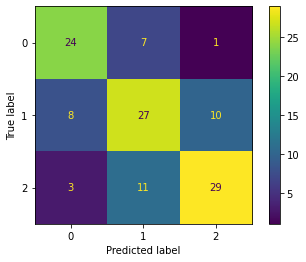

In [13]:
print("Confusion Matrix")
cm = confusion_matrix(test_output, model_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()